In [1]:
#using Pkg

In [2]:
#Pkg.add(url="https://github.com/trappmartin/DeepStructuredMixtures")

In [3]:
using Plots
using DeepStructuredMixtures
using Random

In [4]:
using CSV
using DataFrames

This notebook runs deep structured mixture GPs [https://github.com/trappmartin/DeepStructuredMixtures](https://github.com/trappmartin/DeepStructuredMixtures) for the example in the CPoE paper and the example used in the DSMGP paper.

## a) load data from example in CPoE paper

In [5]:
path = "datasets/deepMixtureGP/";

In [6]:
ytrain = Matrix( CSV.read(path*"y_train.csv", DataFrame, header=0) )[:,1];
Xtrain = Matrix( CSV.read(path*"X_train.csv", DataFrame, header=0) );
Xtest = Matrix( CSV.read(path*"X_test.csv", DataFrame, header=0) );

In [7]:
# use the same kernel and likelihood as full GP

In [8]:
kernOpt = IsoSE( log(0.1), log(sqrt(1.1)) );
lognoiseOpt = log(0.3);
meanOpt = ConstMean(0.);

In [9]:
# use the same parameters as in their example

In [10]:
K = 4 #Number of children under each sum node            # Number of splits per product node
V = 3 #Number of splits at each split node               # Number of children per sum node
M =  10 #10 # Minimum number of observations per expert;

In [11]:
# train the model
model = buildDSMGP(Xtrain, ytrain, K, V; M = M, kernel = kernOpt, meanFun = meanOpt, logNoise=lognoiseOpt);
update!(model);

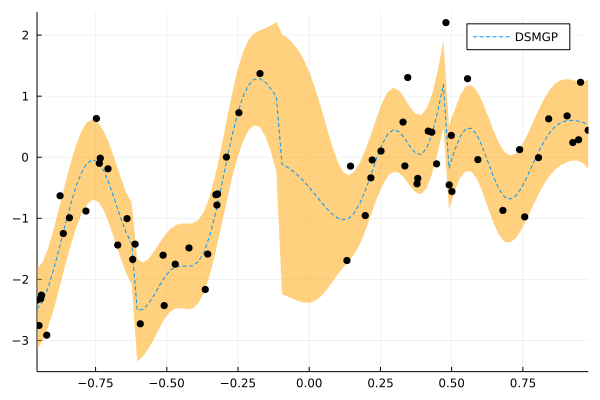

In [12]:
plot(model)

In [13]:
# store predictive means and variances, so that we can load it in notebook comparisonDSM_py

In [14]:
mm, ss = predict(model, Xtest);
vv = ss+exp(lognoiseOpt) *ones(length(ss));

In [15]:
# run if you want to overwrite it (there might be some small differences due to stochastic seed)
#CSV.write(path*"ms_deepStructMix_mixture.csv",  Tables.table(hcat(mm,vv,Xtest)), writeheader=false);

## b) example from DMS paper

In [16]:
# generate training data as in example from DMS paper
xtrain = collect(range(0, stop=1, length = 100))
Xtrain = reshape(xtrain,:,1);
ytrain = sin.(xtrain*4*pi + randn(100)*0.2);

# save it (for CPoE)
CSV.write(path*"ms_deepStructMix_trainingYX.csv",  Tables.table(hcat(ytrain,xtrain)), writeheader=false);

In [17]:
# define kernel and mean function
kernelf = IsoSE(0.1, 1.0)
meanf = ConstMean(mean(xtrain));

In [25]:
# fit a full GP, and fix hyperparameters, so that we can compare the models
modGP = GaussianProcess(Xtrain, ytrain, mean = meanf, kernel = kernelf, logNoise=log(.1))
train!(modGP);

┌ Info: Early stopping at iteration 451 with δ: 0.09698823405322798
└ @ DeepStructuredMixtures /home/manuel/.julia/packages/DeepStructuredMixtures/9lolI/src/optimisers.jl:126


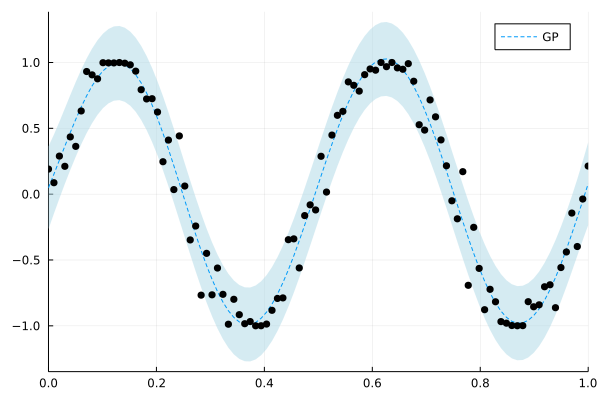

In [26]:
plot(modGP)

In [27]:
# take kernel and noise hyperparameters from full GP
kernOpt = modGP.kernel
lognoiseOpt = modGP.logNoise.value;

In [28]:
# run example from github page of deep structured mixtures (with fixed optimal hyperparameters)

K = 4 # Number of splits per product node
V = 3 # Number of children per sum node
M = 20 # Minimum number of observations per expert

model = buildDSMGP(reshape(xtrain,:,1), ytrain, V, K; M = M, kernel = kernOpt, meanFun = meanf, logNoise=lognoiseOpt)
#train!(model, ADAM())

# finally we perfom exact posterior infence
update!(model);

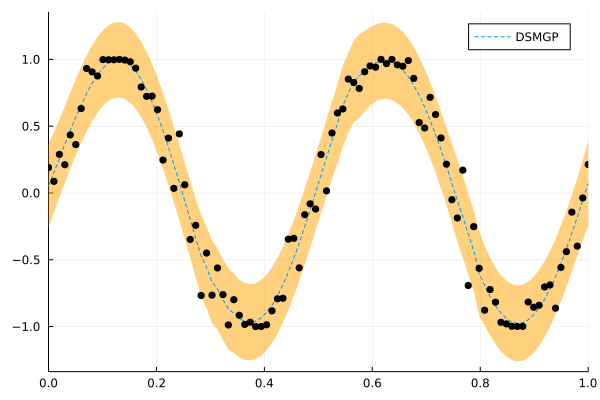

In [29]:
plot(model)

In [30]:
# predict for same xtest data
xtest = collect(range(-0.1, stop=1.1, length = 500))
m, s = predict(model, reshape(xtest,:,1));

In [31]:
# save results and hyperparameters for comparison 
#CSV.write(path*"ms_deepStructMix.csv",  Tables.table(hcat(m,s,xtest)), writeheader=false)
#CSV.write(path*"ms_deepStructMix_hypers.csv",  Tables.table(hcat(exp(kernOpt.logσ), exp(kernOpt.logℓ), exp(lognoiseOpt))), writeheader=false);